# Bitcoin Approach - Data Analysis and Model Evaluation

## Preliminaries

#### Import Libraries

In [ ]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np
import math

# Statistical Tests
from scipy.stats import chi2_contingency, kstest

# Model Implementation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Model Selection
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
import pickle

#### Set Seed for Stochasticity

In [84]:
# Set Random State
SEED = 65163874

## Import & Data Cleaning

#### Import Data

In [85]:
# Import Data
btc_df = pd.read_csv('data/2-btc/address_data/model_data.csv', index_col=0)

# Drop Addresses
btc_df = btc_df.drop(["Address", "Month"], axis=1)

In [86]:
# Show
btc_df['Class'].value_counts()

1    1467
0    1433
Name: Class, dtype: int64

#### Remove Unused Addresses

In [87]:
# Remove Unused Addresses
btc_df = btc_df.loc[(btc_df.drop(["Class"], axis=1)!=0).any(axis=1)]

# Show Data
btc_df

,Total_Rec,Total_Sent,Balance,N_TX,N_Rec,N_Sent,Avg_Rec,Min_Rec,Max_Rec,Avg_Sent,...,Time_Between_FirstLast,Avg_Delta_Rec,Min_Delta_Rec,Max_Delta_Rec,Avg_Delta_Sent,Min_Delta_Sent,Max_Delta_Sent,Unique_Rec,Unique_Sent,Class
0,1090202,1090202,0,2,1,1,1.090202e+06,1090202,1090202,1.090202e+06,...,93037,0.000000e+00,0,0,0.000000e+00,0,0,5,5,1
1,692323608929694,692297356284624,26252645070,469399,100,100,1.562827e+09,920314,4250055812,1.574646e+09,...,19919,2.012020e+02,4,1244,2.012020e+02,4,1244,0,85,1
2,10779416,10779416,0,2,1,1,1.077942e+07,10779416,10779416,1.077942e+07,...,3797843,0.000000e+00,0,0,0.000000e+00,0,0,1,2,1
3,290969,290969,0,2,1,1,2.909690e+05,290969,290969,2.909690e+05,...,1515,0.000000e+00,0,0,0.000000e+00,0,0,1,68,1
4,1074488,1074488,0,2,1,1,1.074488e+06,1074488,1074488,1.074488e+06,...,1833259,0.000000e+00,0,0,0.000000e+00,0,0,5,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,34262,34262,0,2,1,1,3.426200e+04,34262,34262,3.426200e+04,...,4162,0.000000e+00,0,0,0.000000e+00,0,0,1,3,0
2896,1169831498033,1169831498033,0,2183,49,51,1.051427e+09,300000000,3800000000,1.010194e+09,...,12082733,2.504258e+05,0,4308606,2.414993e+05,0,6098711,743,425,0
2897,12885091,12885091,0,18,9,9,1.431677e+06,547,2826933,1.431677e+06,...,67336249,1.883327e+06,0,5433699,8.319017e+06,352667,51504797,1563,572,0
2898,479185,479185,0,5,3,3,1.597283e+05,12768,383991,1.597283e+05,...,9762425,4.866786e+06,0,9733573,3.385090e+06,0,6770181,4,10,0


#### Balance Dataset

In [88]:
# Balance Dataset

# Get Value Counts
counts = pd.DataFrame(btc_df["Class"].value_counts())

# Get Maximum and Minimum
ma = counts[counts["Class"] == max(counts["Class"][0], counts["Class"][1])].values[0][0]
mi = counts[counts["Class"] == min(counts["Class"][0], counts["Class"][1])].values[0][0]

# Get Class with Most Values
ma_i = counts[counts["Class"] == ma].index[0]

# Remove Samples to Match Class with Least Values
btc_df = btc_df.drop(btc_df[btc_df['Class'] == ma_i].sample(ma - mi, random_state=SEED).index)

# Show Result
btc_df["Class"].value_counts()

1    1433
0    1433
Name: Class, dtype: int64

#### Remove Incorrect Data

In [89]:
btc_df = btc_df.drop(btc_df[btc_df['Unique_Rec'] < 1].index)
btc_df

,Total_Rec,Total_Sent,Balance,N_TX,N_Rec,N_Sent,Avg_Rec,Min_Rec,Max_Rec,Avg_Sent,...,Time_Between_FirstLast,Avg_Delta_Rec,Min_Delta_Rec,Max_Delta_Rec,Avg_Delta_Sent,Min_Delta_Sent,Max_Delta_Sent,Unique_Rec,Unique_Sent,Class
0,1090202,1090202,0,2,1,1,1.090202e+06,1090202,1090202,1.090202e+06,...,93037,0.000000e+00,0,0,0.00,0,0,5,5,1
2,10779416,10779416,0,2,1,1,1.077942e+07,10779416,10779416,1.077942e+07,...,3797843,0.000000e+00,0,0,0.00,0,0,1,2,1
3,290969,290969,0,2,1,1,2.909690e+05,290969,290969,2.909690e+05,...,1515,0.000000e+00,0,0,0.00,0,0,1,68,1
4,1074488,1074488,0,2,1,1,1.074488e+06,1074488,1074488,1.074488e+06,...,1833259,0.000000e+00,0,0,0.00,0,0,5,3,0
5,18918000,18918000,0,4,2,2,9.459000e+06,8418000,10500000,9.459000e+06,...,1759219,0.000000e+00,0,0,0.00,0,0,18,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,34262,34262,0,2,1,1,3.426200e+04,34262,34262,3.426200e+04,...,4162,0.000000e+00,0,0,0.00,0,0,1,3,0
2896,1169831498033,1169831498033,0,2183,49,51,1.051427e+09,300000000,3800000000,1.010194e+09,...,12082733,2.504258e+05,0,4308606,241499.34,0,6098711,743,425,0
2897,12885091,12885091,0,18,9,9,1.431677e+06,547,2826933,1.431677e+06,...,67336249,1.883327e+06,0,5433699,8319017.00,352667,51504797,1563,572,0
2898,479185,479185,0,5,3,3,1.597283e+05,12768,383991,1.597283e+05,...,9762425,4.866786e+06,0,9733573,3385090.50,0,6770181,4,10,0


## Feature Extraction

In [90]:
# Ratio of Sent to Received Amounts
btc_df['R_Sent_Rec_Amount'] = btc_df['Total_Sent'] / btc_df['Total_Rec']

# Ratio of Sent to Recieved Addresses
btc_df['R_Sent_Rec_Addr'] = btc_df['Unique_Sent'] / btc_df['Unique_Rec']

# Total Addresses Interacted With
btc_df['Total_Interacted'] = btc_df['Unique_Sent'] + btc_df['Unique_Rec']

# Ratio of Average Amount to Total Amount
btc_df['R_Avg_Total_Rec'] = btc_df['Avg_Rec'] / btc_df['Total_Rec']

# Ratio of Sent to Received TXs
btc_df['R_N_Sent_Rec'] = btc_df['N_Sent'] / btc_df['N_Rec']

# Reused (Bool)
btc_df['Reused'] = np.where(btc_df['N_TX'] > 2, 1, 0)

# Show Data
btc_df

,Total_Rec,Total_Sent,Balance,N_TX,N_Rec,N_Sent,Avg_Rec,Min_Rec,Max_Rec,Avg_Sent,...,Max_Delta_Sent,Unique_Rec,Unique_Sent,Class,R_Sent_Rec_Amount,R_Sent_Rec_Addr,Total_Interacted,R_Avg_Total_Rec,R_N_Sent_Rec,Reused
0,1090202,1090202,0,2,1,1,1.090202e+06,1090202,1090202,1.090202e+06,...,0,5,5,1,1.0,1.000000,10,1.000000,1.000000,0
2,10779416,10779416,0,2,1,1,1.077942e+07,10779416,10779416,1.077942e+07,...,0,1,2,1,1.0,2.000000,3,1.000000,1.000000,0
3,290969,290969,0,2,1,1,2.909690e+05,290969,290969,2.909690e+05,...,0,1,68,1,1.0,68.000000,69,1.000000,1.000000,0
4,1074488,1074488,0,2,1,1,1.074488e+06,1074488,1074488,1.074488e+06,...,0,5,3,0,1.0,0.600000,8,1.000000,1.000000,0
5,18918000,18918000,0,4,2,2,9.459000e+06,8418000,10500000,9.459000e+06,...,0,18,32,0,1.0,1.777778,50,0.500000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,34262,34262,0,2,1,1,3.426200e+04,34262,34262,3.426200e+04,...,0,1,3,0,1.0,3.000000,4,1.000000,1.000000,0
2896,1169831498033,1169831498033,0,2183,49,51,1.051427e+09,300000000,3800000000,1.010194e+09,...,6098711,743,425,0,1.0,0.572005,1168,0.000899,1.040816,1
2897,12885091,12885091,0,18,9,9,1.431677e+06,547,2826933,1.431677e+06,...,51504797,1563,572,0,1.0,0.365963,2135,0.111111,1.000000,1
2898,479185,479185,0,5,3,3,1.597283e+05,12768,383991,1.597283e+05,...,6770181,4,10,0,1.0,2.500000,14,0.333333,1.000000,1


## Data Analysis

#### Variable Types

In [91]:
# Categorical Variables
cat = ["Reused"]

# Numerical Variables
num = [x for x in list(btc_df.keys()) if x not in ["Class", "Reused"]]

#### Number of Stats Tests (For Bonferroni Correction)

In [92]:
# Each Feature Tested for Normality and Correlation
num_tests = len(cat)        # Chi2 for Each Variable
num_tests += len(num)       # Chi2 for Each Variable

#### Define Dataframes

In [93]:
norm_df = pd.DataFrame(columns=["Feature", "Adjusted P-Value"])

In [94]:
corr_df = pd.DataFrame(columns=["Feature", "Coefficient", "Adjusted P-Value"])

#### Categorical Variables

In [95]:
# Encode String Categories to Numbers
for feat in cat:
    btc_df[feat] = pd.factorize(btc_df[feat])[0]

In [96]:
# Get Strength of Correlation
for feat in cat:

    # Check for Association
    cross_tab = pd.crosstab(btc_df["Class"], btc_df[feat])
    chi2, p, _, _ = chi2_contingency(cross_tab)

    # Calculate Cramer's V Coefficient
    n = cross_tab.sum().sum()
    cramers_v = np.sqrt(chi2 / (n*(min(cross_tab.shape)-1)))

    # Insert New Row
    corr_df.loc[len(corr_df)] = {"Feature": feat, "Coefficient": cramers_v, "Adjusted P-Value": p * num_tests}

#### Numerical Variables

In [97]:
# Check Normality

# Theoretical Normal Distribution
theoretical = np.random.randn(len(btc_df))

# Conduct KS-Tests
for feat in num:
    theoretical = np.random.randn(len(btc_df[feat]))
    st, p = kstest(btc_df[feat], theoretical)
    norm_df.loc[len(norm_df)] = {"Feature": feat, "Statistic": st, "Adjusted P-Value": p * num_tests}

In [98]:
norm_df

,Feature,Adjusted P-Value
0,Total_Rec,0.000000e+00
1,Total_Sent,0.000000e+00
2,Balance,0.000000e+00
3,N_TX,0.000000e+00
4,N_Rec,0.000000e+00
5,N_Sent,0.000000e+00
6,Avg_Rec,0.000000e+00
7,Min_Rec,0.000000e+00
8,Max_Rec,0.000000e+00
9,Avg_Sent,0.000000e+00


In [99]:
# Dichotomise Variables by Median
medians = btc_df[num].median()
dichotomise = lambda col: (col > medians[col.name]).astype(int)
di_num_df = btc_df[num].drop("R_Sent_Rec_Amount", axis=1).apply(dichotomise, axis=0)

# R_Sent_Rec_Amount by Mean - This Has A Max Value of 1 and a Median of 1.
mean = btc_df['R_Sent_Rec_Amount'].mean()
di_num_df['R_Sent_Rec_Amount'] = np.where(btc_df['R_Sent_Rec_Amount'] > mean, 1, 0)

# Show
di_num_df

,Total_Rec,Total_Sent,Balance,N_TX,N_Rec,N_Sent,Avg_Rec,Min_Rec,Max_Rec,Avg_Sent,...,Avg_Delta_Sent,Min_Delta_Sent,Max_Delta_Sent,Unique_Rec,Unique_Sent,R_Sent_Rec_Addr,Total_Interacted,R_Avg_Total_Rec,R_N_Sent_Rec,R_Sent_Rec_Amount
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,1,0,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5,1,1,0,0,0,0,1,1,1,1,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2896,1,1,0,1,1,1,1,1,1,1,...,1,0,1,1,1,0,1,0,1,1
2897,1,1,0,1,1,1,0,0,0,0,...,1,1,1,1,1,0,1,0,0,1
2898,0,0,0,1,1,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1


In [100]:
# Get Strength of Correlation
for feat in num:

    # Check Association
    cross_tab = pd.crosstab(btc_df["Class"], di_num_df[feat])
    chi2, p, _, _ = chi2_contingency(cross_tab)

    # Calculate Phi Coefficient
    n = cross_tab.sum().sum()
    phi = np.sqrt(chi2 / (n*(min(cross_tab.shape)-1)))

    # Insert New Row
    corr_df.loc[len(corr_df)] = {"Feature": feat, "Coefficient": phi, "Adjusted P-Value": p * num_tests}

#### Results

In [102]:
corr_df

,Feature,Coefficient,Adjusted P-Value
0,Reused,0.260161,1.423562e-42
1,Total_Rec,0.154546,3.773672e-15
2,Total_Sent,0.141958,8.519790e-13
3,Balance,0.106555,3.263983e-07
4,N_TX,0.198061,8.755313e-25
5,N_Rec,0.224495,8.945623e-32
6,N_Sent,0.197356,1.309139e-24
7,Avg_Rec,0.174126,3.384496e-19
8,Min_Rec,0.062238,2.358229e-02
9,Max_Rec,0.209091,1.349038e-27


In [103]:
def plot_coeffs(title, data):
    # Create Plot
    ax = sns.barplot(x='Feature', y='Coefficient', data=data, palette=data['Color'])

    # Set Labels
    ax.set_title(title)
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Coefficient")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', marker='s', linestyle='', markersize=10, label='Significant'),
        plt.Line2D([0], [0], color='red', marker='s', linestyle='', markersize=10, label='Not Significant')
    ]

    plt.legend(handles=legend_elements)

    # Save Image
    plt.savefig("figures/btc/" + title + ".pdf", format="pdf", bbox_inches="tight")

    # Show Plot
    plt.show()

In [104]:
# Prep For Plot

# Get Column Color
corr_df['Significant'] = [True if x < 0.05 else False for x in corr_df['Adjusted P-Value']]
corr_df['Color'] = corr_df['Significant'].map({True: "green", False: "red"})

# Sort Ascending Coefficient
corr_df = corr_df.sort_values('Coefficient')

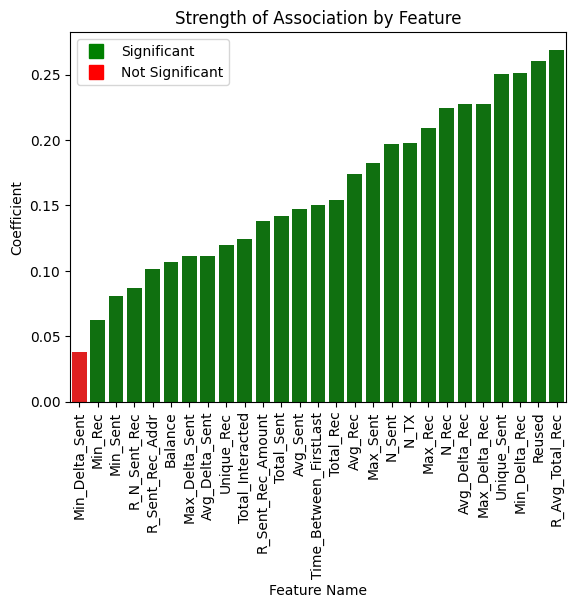

In [105]:
# All Features
plot_coeffs("Strength of Association by Feature", corr_df)

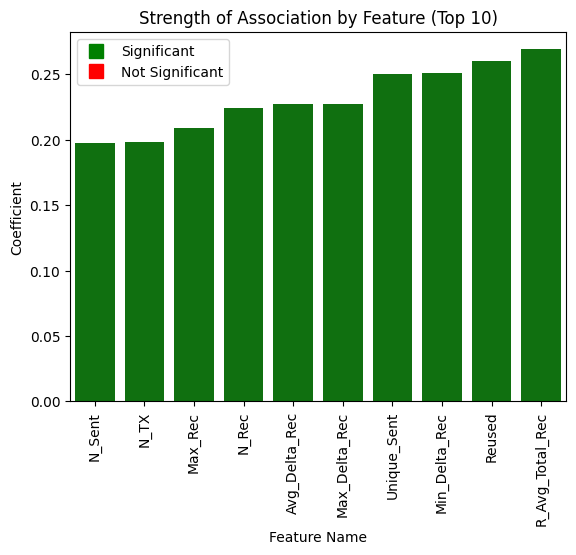

In [106]:
# Top 10
plot_coeffs("Strength of Association by Feature (Top 10)", corr_df.tail(10))

## Model Implementation

#### Pre-Processing

In [107]:
# Split Target/Features
x = btc_df.drop(['Class'], axis=1)
y = btc_df["Class"]

In [108]:
# Get Features List
chosen = list(corr_df.loc[(corr_df["Adjusted P-Value"] < 0.05) & (corr_df['Coefficient'] >= 0.2)]["Feature"])
x = x[chosen]
x.keys()

Index(['Max_Rec', 'N_Rec', 'Avg_Delta_Rec', 'Max_Delta_Rec', 'Unique_Sent',
       'Min_Delta_Rec', 'Reused', 'R_Avg_Total_Rec'],
      dtype='object')

In [109]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=SEED)

#### Optimisation

In [110]:
def optimise(x_tr, y_tr):
    # Define Parameter Grid
    rf_grid = {
        "n_estimators": [1, 25, 50, 75, 100],
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": [1, 10, 100, 1000, None],
        "min_samples_split": [2, 10, 20, 30, 40],
        "min_samples_leaf": [1, 5, 10, 20],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False],
        "random_state":[SEED]
    }

    # Perform Cross Validation
    splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    rf_cv = GridSearchCV(estimator=RandomForestClassifier(),
                         param_grid=rf_grid,
                         cv=splitter,
                         n_jobs=-1,
                         scoring='accuracy',
                         refit=True)

    # Grid Search
    return rf_cv.fit(x_tr, y_tr)

In [111]:
# Perform Optimisation
res = optimise(x_train, y_train)

In [112]:
# Show Best Model Parameters
res.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 50,
 'random_state': 65163874}

## Model Evaluation

#### Make Predictions

In [113]:
# Get Best Model
rf = res.best_estimator_

In [114]:
# Make Predictions
y_pred = rf.predict(x_test)

#### Metrics

In [115]:
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# 95% Confidence Interval
ci = 1.96 * math.sqrt((acc * (1 - acc)) / len(y_test))
print("CI: %.3f" % ci)

F1 Score:  0.7441860465116278
Accuracy:  0.7384615384615385
CI: 0.032


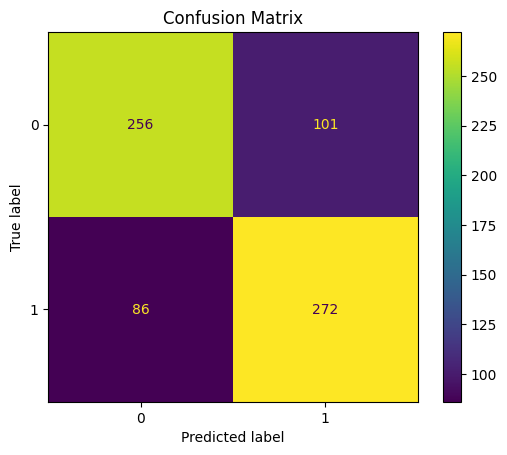

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("figures/btc/" + "Confusion Matrix 1" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Save Model

In [117]:
pickle.dump(rf, open('models/rf_btc.pickle', 'wb'))

## Improvement Attemps

#### Attempt with More Features

In [118]:
# Split Target/Features
x = btc_df.drop(['Class'], axis=1)
y = btc_df["Class"]

In [119]:
# Get Features List
chosen = list(corr_df.loc[(corr_df['Adjusted P-Value'] < 0.05)]["Feature"])
x = x[chosen]
x

,Min_Rec,Min_Sent,R_N_Sent_Rec,R_Sent_Rec_Addr,Balance,Max_Delta_Sent,Avg_Delta_Sent,Unique_Rec,Total_Interacted,R_Sent_Rec_Amount,...,N_Sent,N_TX,Max_Rec,N_Rec,Avg_Delta_Rec,Max_Delta_Rec,Unique_Sent,Min_Delta_Rec,Reused,R_Avg_Total_Rec
0,1090202,1090202,1.000000,1.000000,0,0,0.00,5,10,1.0,...,1,2,1090202,1,0.000000e+00,0,5,0,0,1.000000
2,10779416,10779416,1.000000,2.000000,0,0,0.00,1,3,1.0,...,1,2,10779416,1,0.000000e+00,0,2,0,0,1.000000
3,290969,290969,1.000000,68.000000,0,0,0.00,1,69,1.0,...,1,2,290969,1,0.000000e+00,0,68,0,0,1.000000
4,1074488,1074488,1.000000,0.600000,0,0,0.00,5,8,1.0,...,1,2,1074488,1,0.000000e+00,0,3,0,0,1.000000
5,8418000,8418000,1.000000,1.777778,0,0,0.00,18,50,1.0,...,2,4,10500000,2,0.000000e+00,0,32,0,1,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,34262,34262,1.000000,3.000000,0,0,0.00,1,4,1.0,...,1,2,34262,1,0.000000e+00,0,3,0,0,1.000000
2896,300000000,547,1.040816,0.572005,0,6098711,241499.34,743,1168,1.0,...,51,2183,3800000000,49,2.504258e+05,4308606,425,0,1,0.000899
2897,547,547,1.000000,0.365963,0,51504797,8319017.00,1563,2135,1.0,...,9,18,2826933,9,1.883327e+06,5433699,572,0,1,0.111111
2898,12768,12768,1.000000,2.500000,0,6770181,3385090.50,4,14,1.0,...,3,5,383991,3,4.866786e+06,9733573,10,0,1,0.333333


In [120]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=SEED)

In [121]:
# Perform Optimisation
res = optimise(x_train, y_train)

In [122]:
# Show Best Model Parameters
res.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 75,
 'random_state': 65163874}

In [123]:
# Get Best Model
rf = res.best_estimator_

In [124]:
# Make Predictions
y_pred = rf.predict(x_test)

In [125]:
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# 95% Confidence Interval
ci = 1.96 * math.sqrt((acc * (1 - acc)) / len(y_test))
print("CI: %.3f" % ci)

F1 Score:  0.7381275440976933
Accuracy:  0.73006993006993
CI: 0.033


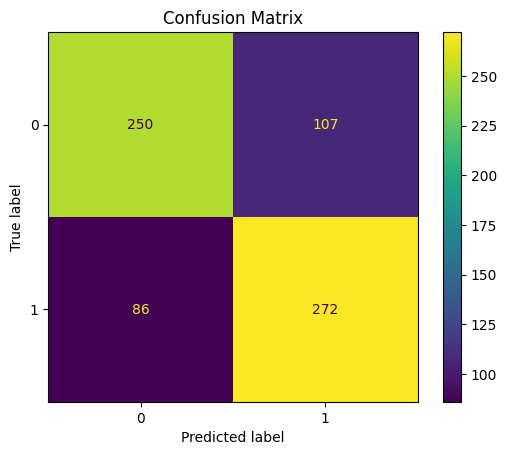

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("figures/btc/" + "Confusion Matrix 2" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()